In [1]:
# 0) Install (safe)
!pip -q install -U tqdm pillow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 95.6 MB/s eta 0:00:00


In [2]:
# 1) Imports & config
import os, random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm

# ---------- Repro & device ----------
SEED = 1337
def seed_everything(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ---------- Paths (your repo already cloned) ----------
# If you haven't cloned in this runtime yet, uncomment:
!git clone https://github.com/Gaabshiine/pycon-2025-hackthon.git
BASE_DIR   = Path('/content/pycon-2025-hackthon')
IMAGES_DIR = BASE_DIR / 'Images'
TRAIN_CSV  = BASE_DIR / 'Train.csv'
TEST_CSV   = BASE_DIR / 'Test.csv'
SAMPLE_SUB = BASE_DIR / 'SampleSubmission.csv'
assert TRAIN_CSV.exists() and TEST_CSV.exists() and IMAGES_DIR.exists()

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
print(train_df.head())

# ---------- T4-friendly hparams ----------

# Resnet18 when I used:
# IMG_SIZE    = 256          # try 320 if VRAM allows.
# BATCH_SIZE  = 64           # 48/32 if OOM
# NUM_WORKERS = 0            # avoids Colab multiprocessing assertion
# PIN_MEMORY  = True
# BACKBONE = "resnet18"      # "resnet18" or "resnet34"
# FOLDS    = 3


# Resnet34 when I used:
IMG_SIZE = 320
BATCH_SIZE = 32 # 48/32 if OOM
NUM_WORKERS = 0 # avoids Colab multiprocessing assertion
PIN_MEMORY = True
BACKBONE = "resnet34"
FOLDS = 5

EPOCHS          = 15
LR              = 3e-4
WARMUP_EPOCHS   = 1
WEIGHT_DECAY    = 1e-4
SMOOTH_EPS      = 0.05     # label smoothing





# ---------- AMP (new API) ----------
from contextlib import nullcontext
autocast_ctx = torch.amp.autocast if torch.cuda.is_available() else nullcontext
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None

Using device: cuda
Cloning into 'pycon-2025-hackthon'...
remote: Enumerating objects: 2781, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 2781 (delta 31), reused 50 (delta 15), pack-reused 2707 (from 1)
Receiving objects: 100% (2781/2781), 376.53 MiB | 27.91 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Updating files: 100% (2717/2717), done.
               Image_id  Label
0  id_02amazy34fgh2.jpg      1
1  id_02mh3w48pmyc9.jpg      0
2  id_02rpb463h9d3w.jpg      0
3  id_02wc3jeeao8ol.jpg      1
4  id_03t2hapb8wz8p.jpg      1


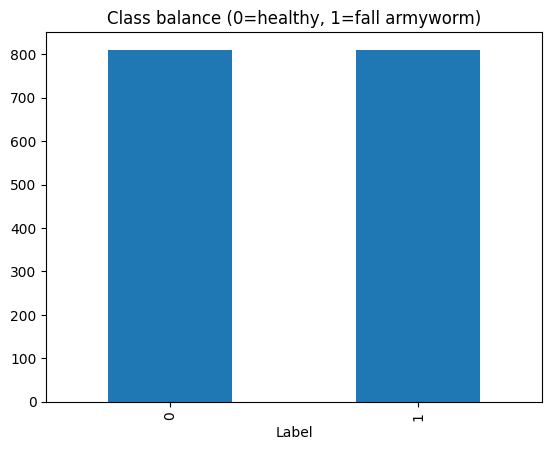

In [3]:
# 2) Quick EDA (optional)
train_df['Label'].value_counts().sort_index().plot(kind="bar", title="Class balance (0=healthy, 1=fall armyworm)")
plt.show()

In [4]:
# 3) Dataset & transforms
class MaizeDataset(Dataset):
    def __init__(self, df, images_dir, mode='train', transform=None):
        self.df = df.reset_index(drop=True)
        self.images_dir = Path(images_dir)
        self.mode = mode
        self.transform = transform

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.images_dir / row['Image_id']  # CSV already has .jpg
        img = Image.open(img_path).convert('RGB')
        if self.transform: img = self.transform(img)
        if self.mode == 'test':
            return img, row['Image_id']
        else:
            label = torch.tensor(float(row['Label']), dtype=torch.float32)
            return img, label


# when I used resnet18 re-build transforms for the current IMG_SIZE related
# train_tfms = transforms.Compose([
#     transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
# ])
# valid_tfms = transforms.Compose([
#     transforms.Resize(IMG_SIZE+32),
#     transforms.CenterCrop(IMG_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
# ])



# when I used resnet34 re-build transforms for the current IMG_SIZE related
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
valid_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE+32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [5]:
# 4) Model, loss, scheduler
def build_model():
    if BACKBONE == "resnet34":
        m = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    else:
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_feats = m.fc.in_features
    m.fc = nn.Linear(in_feats, 1)
    return m

def bce_with_logits_smooth(logits, labels, eps=SMOOTH_EPS):
    # Smooth labels toward 0.5 to regularize
    labels_s = labels * (1 - eps) + 0.5 * eps
    return F.binary_cross_entropy_with_logits(logits, labels_s)

def make_scheduler(optimizer):
    def lr_lambda(e):
        if e < WARMUP_EPOCHS:      # linear warmup
            return (e + 1) / max(1, WARMUP_EPOCHS)
        t = (e - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
        return 0.5 * (1 + np.cos(np.pi * t))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

class EarlyStopper:
    def __init__(self, patience=3):
        self.best = -np.inf; self.wait = 0; self.patience = patience
    def step(self, val):
        if val > self.best + 1e-4: self.best = val; self.wait = 0; return True
        self.wait += 1; return False
    def should_stop(self): return self.wait >= self.patience

In [6]:
# 5) Train / Eval loops
def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    total = 0.0
    for imgs, labels in tqdm(loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)
        with autocast_ctx('cuda'):
            logits = model(imgs)
            loss = bce_with_logits_smooth(logits, labels)
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total += loss.item() * imgs.size(0)
    return total / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_probs, all_targets = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1)
        with autocast_ctx('cuda'):
            probs = torch.sigmoid(model(imgs))
        all_probs.append(probs.cpu().numpy())
        all_targets.append(labels.cpu().numpy())
    probs = np.concatenate(all_probs).ravel()
    targs = np.concatenate(all_targets).ravel()
    return roc_auc_score(targs, probs)

In [7]:
# 6) TTA inference helper
@torch.no_grad()
def predict_tta(model, imgs):
    # orig + hflip + vflip (×3)
    with autocast_ctx('cuda'):
        logits  = model(imgs)
        logits += model(torch.flip(imgs, [3]))
        logits += model(torch.flip(imgs, [2]))
    return torch.sigmoid(logits / 3.0)

In [8]:
# 7) 3-fold CV training + ensemble submission

# training CV for resnet18
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# test_ds = MaizeDataset(test_df, IMAGES_DIR, 'test', valid_tfms)
# test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
#                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# test_preds = np.zeros(len(test_df), dtype=np.float32)

# for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df['Image_id'], train_df['Label']), 1):
#     print(f"\n========== Fold {fold}/{FOLDS} ==========")
#     tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
#     va_df = train_df.iloc[va_idx].reset_index(drop=True)

#     tr_ds = MaizeDataset(tr_df, IMAGES_DIR, 'train', train_tfms)
#     va_ds = MaizeDataset(va_df, IMAGES_DIR, 'train', valid_tfms)

#     tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,
#                            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
#     va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False,
#                            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

#     model = build_model().to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
#     scheduler = make_scheduler(optimizer)
#     early = EarlyStopper(patience=3)

#     best_path = BASE_DIR / f'best_{BACKBONE}_fold{fold}.pt'
#     best_auc = -1

#     for epoch in range(1, EPOCHS + 1):
#         loss = train_one_epoch(model, tr_loader, optimizer, scaler)
#         val_auc = evaluate(model, va_loader)
#         print(f"Fold {fold} | Epoch {epoch:02d} | loss {loss:.4f} | val_auc {val_auc:.6f}")
#         if early.step(val_auc):
#             torch.save(model.state_dict(), best_path)
#             best_auc = val_auc
#             print("  ✓ Saved best")
#         scheduler.step()
#         if early.should_stop():
#             print("  Early stopping.")
#             break

#     # Load best & predict test
#     model.load_state_dict(torch.load(best_path, map_location=device))
#     model.eval()
#     fold_probs = []
#     for imgs, _ids in tqdm(test_loader, leave=False):
#         imgs = imgs.to(device, non_blocking=True)
#         p = predict_tta(model, imgs).cpu().numpy().ravel()
#         fold_probs.append(p)
#     fold_probs = np.concatenate(fold_probs)
#     test_preds += fold_probs / FOLDS
#     print(f"Fold {fold} best AUC: {best_auc:.6f}")

# # Save ensemble submission
# sub = pd.DataFrame({'Image_id': test_df['Image_id'], 'Label': test_preds})
# sub_path = BASE_DIR / f'submission_cv{FOLDS}_{BACKBONE}_img{IMG_SIZE}.csv'
# sub.to_csv(sub_path, index=False)
# print(sub.head(), "\nSaved:", sub_path)


# this is 5 fold testing
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

test_ds = MaizeDataset(test_df, IMAGES_DIR, 'test', valid_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=0, pin_memory=True)

test_preds = np.zeros(len(test_df), dtype=np.float32)

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df['Image_id'], train_df['Label']), 1):
    print(f"\n========== Fold {fold}/{FOLDS} ==========")
    tr_df = train_df.iloc[tr_idx].reset_index(drop=True)
    va_df = train_df.iloc[va_idx].reset_index(drop=True)

    tr_loader = DataLoader(MaizeDataset(tr_df, IMAGES_DIR, 'train', train_tfms),
                           batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    va_loader = DataLoader(MaizeDataset(va_df, IMAGES_DIR, 'train', valid_tfms),
                           batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    model = build_model().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = make_scheduler(optimizer)
    early = EarlyStopper(patience=3)

    best_path = BASE_DIR / f'best_{BACKBONE}_fold{fold}.pt'
    best_auc = -1

    for epoch in range(1, EPOCHS + 1):
        loss = train_one_epoch(model, tr_loader, optimizer, scaler)
        val_auc = evaluate(model, va_loader)
        print(f"Fold {fold} | Epoch {epoch:02d} | loss {loss:.4f} | val_auc {val_auc:.6f}")
        if early.step(val_auc):
            torch.save(model.state_dict(), best_path)
            best_auc = val_auc
            print("  ✓ Saved best")
        scheduler.step()
        if early.should_stop():
            print("  Early stopping.")
            break

    model.load_state_dict(torch.load(best_path, map_location=device))
    model.eval()
    fold_probs = []
    for imgs, _ in tqdm(test_loader, leave=False):
        imgs = imgs.to(device, non_blocking=True)
        p = predict_tta(model, imgs).cpu().numpy().ravel()
        fold_probs.append(p)
    test_preds += np.concatenate(fold_probs) / FOLDS
    print(f"Fold {fold} best AUC: {best_auc:.6f}")

sub5 = pd.DataFrame({'Image_id': test_df['Image_id'], 'Label': test_preds})
sub5_path = BASE_DIR / f'submission_cv5_{BACKBONE}_img{IMG_SIZE}.csv'
sub5.to_csv(sub5_path, index=False)
print("Saved:", sub5_path)


========== Fold 1/5 ==========
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 108MB/s]


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 1 | Epoch 01 | loss 0.2119 | val_auc 0.998514
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 1 | Epoch 02 | loss 0.1502 | val_auc 0.999695
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 1 | Epoch 03 | loss 0.1399 | val_auc 0.999543


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 1 | Epoch 04 | loss 0.1328 | val_auc 0.998552


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 1 | Epoch 05 | loss 0.1294 | val_auc 0.998400
  Early stopping.


  0%|          | 0/34 [00:00<?, ?it/s]

Fold 1 best AUC: 0.999695

========== Fold 2/5 ==========


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 2 | Epoch 01 | loss 0.2188 | val_auc 0.999809
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 2 | Epoch 02 | loss 0.1528 | val_auc 0.998819


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 2 | Epoch 03 | loss 0.1354 | val_auc 0.999886


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 2 | Epoch 04 | loss 0.1395 | val_auc 1.000000
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 2 | Epoch 05 | loss 0.1381 | val_auc 1.000000


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 2 | Epoch 06 | loss 0.1249 | val_auc 1.000000


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 2 | Epoch 07 | loss 0.1240 | val_auc 0.999962
  Early stopping.


  0%|          | 0/34 [00:00<?, ?it/s]

Fold 2 best AUC: 1.000000

========== Fold 3/5 ==========


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 3 | Epoch 01 | loss 0.2054 | val_auc 0.997257
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 3 | Epoch 02 | loss 0.1574 | val_auc 0.999809
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 3 | Epoch 03 | loss 0.1361 | val_auc 0.999543


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 3 | Epoch 04 | loss 0.1316 | val_auc 0.999657


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 3 | Epoch 05 | loss 0.1269 | val_auc 0.999390
  Early stopping.


  0%|          | 0/34 [00:00<?, ?it/s]

Fold 3 best AUC: 0.999809

========== Fold 4/5 ==========


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 4 | Epoch 01 | loss 0.2136 | val_auc 0.999505
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 4 | Epoch 02 | loss 0.1614 | val_auc 1.000000
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 4 | Epoch 03 | loss 0.1389 | val_auc 1.000000


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 4 | Epoch 04 | loss 0.1358 | val_auc 1.000000


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 4 | Epoch 05 | loss 0.1312 | val_auc 1.000000
  Early stopping.


  0%|          | 0/34 [00:00<?, ?it/s]

Fold 4 best AUC: 1.000000

========== Fold 5/5 ==========


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 5 | Epoch 01 | loss 0.2064 | val_auc 0.999387
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 5 | Epoch 02 | loss 0.1490 | val_auc 0.999770
  ✓ Saved best


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 5 | Epoch 03 | loss 0.1426 | val_auc 0.999770


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 5 | Epoch 04 | loss 0.1536 | val_auc 0.994172


  0%|          | 0/41 [00:00<?, ?it/s]

Fold 5 | Epoch 05 | loss 0.1331 | val_auc 0.999655
  Early stopping.


  0%|          | 0/34 [00:00<?, ?it/s]

Fold 5 best AUC: 0.999770
Saved: /content/pycon-2025-hackthon/submission_cv5_resnet34_img320.csv


In [9]:
# -------------------------
# BLEND: ResNet34@320 (5-fold) + ResNet18@256 (3-fold)
# Output: submissions/submission_blend_r18r34_40_60.csv
# -------------------------


# from pathlib import Path
# import pandas as pd

# BASE_DIR = Path('/content/pycon-2025-hackthon')
# SUB_DIR = BASE_DIR / 'submissions'

# # Input files (make sure both exist in your repo)
# r34_path = SUB_DIR / 'submission_cv5_resnet34_img320.csv'
# r18_path = SUB_DIR / 'submission_cv3_resnet18_img256.csv'

# # Load both
# r34 = pd.read_csv(r34_path)
# r18 = pd.read_csv(r18_path)

# # Sanity check
# assert set(r34.columns) == {'Image_id', 'Label'}
# assert set(r18.columns) == {'Image_id', 'Label'}
# assert len(r34) == len(r18)

# # Blend (60% ResNet34, 40% ResNet18)
# blend = r34.merge(r18, on='Image_id', suffixes=('_r34', '_r18'))
# blend['Label'] = 0.60 * blend['Label_r34'] + 0.40 * blend['Label_r18']

# # Save blended file
# blend_out = blend[['Image_id', 'Label']]
# blend_path = SUB_DIR / 'submission_blend_r18r34_40_60.csv'
# blend_out.to_csv(blend_path, index=False)

# print("Saved blend:", blend_path)
# print(blend_out.head())
